## Clustering

### Dataset: Marketing in Banking

Source: https://www.kaggle.com/janiobachmann/bank-marketing-dataset

(Original source: https://archive.ics.uci.edu/ml/datasets/bank+marketing)

#### Input variables:

##### bank client data:
 1. age (numeric)
 2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
 3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
 4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
 5. default: has credit in default? (categorical: 'no','yes','unknown')
 6. housing: has housing loan? (categorical: 'no','yes','unknown')
 7. loan: has personal loan? (categorical: 'no','yes','unknown')

##### related with the last contact of the current campaign:
 8. contact: contact communication type (categorical: 'cellular','telephone') 
 9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
 11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### other attributes:
 12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
 14. previous: number of contacts performed before this campaign and for this client (numeric)
 15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### social and economic context attributes
 16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
 17. cons.price.idx: consumer price index - monthly indicator (numeric) 
 18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
 19. euribor3m: euribor 3 month rate - daily indicator (numeric)
 20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
 21. y - has the client subscribed a term deposit? (binary: 'yes','no')
 
### Tasks

- Explore clustering algorithms on the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
target = 'deposit'

# can experiment here, with omitting some columns
# that you think won't make sense

# when doing this, re-run the notebook (including read_csv) from beginning so that
# the LabelEncode will not be accidentally run twice. 
features = df.columns[(df.columns != target) & 
                      (df.columns != 'day') &
                      (df.columns != 'month')]

## Data cleaning

In [5]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

No NaN values to clean!

But there are quite a few categorical features to convert to encode.

## Categorical data encoding

In [6]:
df[features].dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [7]:
for f in features:
    if (df[f].dtypes == 'object'):
        print(f, df[f].unique())

job ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital ['married' 'single' 'divorced']
education ['secondary' 'tertiary' 'primary' 'unknown']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
poutcome ['unknown' 'other' 'failure' 'success']


For simplicity, let's label encode these categorical features.

How to one-hot encode, for reference:
```
pd.get_dummies(df['marital'])
```

In [8]:
from sklearn.preprocessing import LabelEncoder

# store encoders in a dictionary so that we can refer to them easily for using / saving / loading
encoders = dict()

for f in features:
    if (df[f].dtypes == 'object'):
        encoder = LabelEncoder()
        encoder.fit(df[f])        
        df[f] = encoder.transform(df[f])
        encoders[f] = encoder

In [9]:
# inspect the encoders
encoders

{'job': LabelEncoder(),
 'marital': LabelEncoder(),
 'education': LabelEncoder(),
 'default': LabelEncoder(),
 'housing': LabelEncoder(),
 'loan': LabelEncoder(),
 'contact': LabelEncoder(),
 'poutcome': LabelEncoder()}

In [10]:
# inspect the encoded classes
for k, v in encoders.items():
    print(k, df[k].unique(), v.classes_)

job [ 0  9  7  4  5  1 10  2  3 11  6  8] ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital [1 2 0] ['divorced' 'married' 'single']
education [1 2 0 3] ['primary' 'secondary' 'tertiary' 'unknown']
default [0 1] ['no' 'yes']
housing [1 0] ['no' 'yes']
loan [0 1] ['no' 'yes']
contact [2 0 1] ['cellular' 'telephone' 'unknown']
poutcome [3 1 0 2] ['failure' 'other' 'success' 'unknown']


## Data exploration

In [11]:
df.corr()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,pdays,previous,poutcome
age,1.000000,-0.031603,-0.442782,-0.126018,-0.011425,0.112300,-0.168700,-0.031418,0.027762,-0.000762,0.000189,-0.005278,0.002774,0.020169,-0.002699
job,-0.031603,1.000000,0.078314,0.147046,-0.007066,0.028736,-0.136965,-0.067092,-0.087915,0.026589,0.002432,0.003104,-0.003385,0.012665,-0.004238
marital,-0.442782,0.078314,1.000000,0.125845,-0.014691,-0.002138,-0.036345,-0.062029,-0.060456,-0.003642,0.006781,-0.030794,0.031200,0.031281,-0.039424
education,-0.126018,0.147046,0.125845,1.000000,-0.010709,0.051728,-0.109168,-0.073154,-0.132540,0.016759,-0.019122,-0.005327,0.025165,0.022427,-0.040262
default,-0.011425,-0.007066,-0.014691,-0.010709,1.000000,-0.060954,0.011076,0.076434,0.035709,0.017342,-0.009760,0.030975,-0.036282,-0.035273,0.042357
balance,0.112300,0.028736,-0.002138,0.051728,-0.060954,1.000000,-0.077092,-0.084589,-0.027295,0.010467,0.022436,-0.013894,0.017411,0.030805,-0.027151
housing,-0.168700,-0.136965,-0.036345,-0.109168,0.011076,-0.077092,1.000000,0.076761,0.226392,-0.014770,0.035051,0.006660,0.064497,-0.000840,-0.046370
loan,-0.031418,-0.067092,-0.062029,-0.073154,0.076434,-0.084589,0.076761,1.000000,0.006829,0.017269,-0.001914,0.034722,-0.030416,-0.022668,0.026344
contact,0.027762,-0.087915,-0.060456,-0.132540,0.035709,-0.027295,0.226392,0.006829,1.000000,0.007943,-0.018000,0.059258,-0.227785,-0.169919,0.257993
day,-0.000762,0.026589,-0.003642,0.016759,0.017342,0.010467,-0.014770,0.017269,0.007943,1.000000,-0.018511,0.137007,-0.077232,-0.058981,0.080221


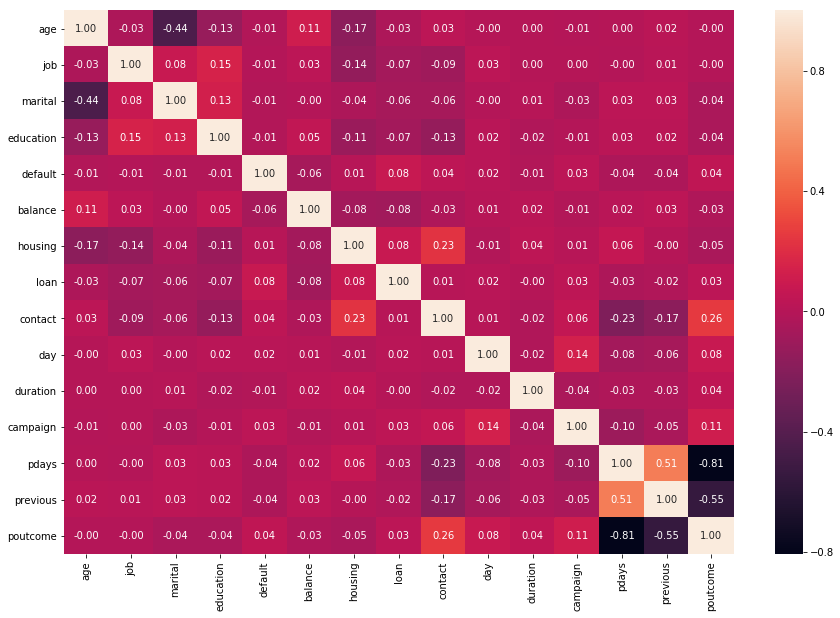

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', ax=ax)

## Data visualisation using PCA

In [13]:
# check ranges to see if we need to scale before PCA
df[features].describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,4.487905,1.199337,1.285164,0.015051,1528.538524,0.473123,0.130801,0.489697,371.993818,2.508421,51.330407,0.832557,2.477782
std,11.913369,3.225132,0.625552,0.749478,0.121761,3225.413326,0.499299,0.337198,0.818724,347.128386,2.722077,108.758282,2.292007,1.002952
min,18.000000,0.000000,0.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,1.000000,1.000000,1.000000,0.000000,122.000000,0.000000,0.000000,0.000000,138.000000,1.000000,-1.000000,0.000000,2.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,550.000000,0.000000,0.000000,0.000000,255.000000,2.000000,-1.000000,0.000000,3.000000
75%,49.000000,7.000000,2.000000,2.000000,0.000000,1708.000000,1.000000,0.000000,1.000000,496.000000,3.000000,20.750000,1.000000,3.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,81204.000000,1.000000,1.000000,2.000000,3881.000000,63.000000,854.000000,58.000000,3.000000


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[Text(0, 0.5, 'Z[1]'), Text(0.5, 0, 'Z[0]'), Text(0.5, 1.0, '2-d PCA plot')]

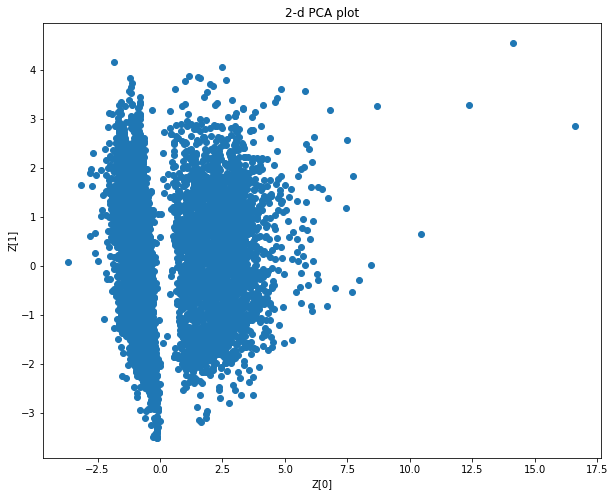

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scale for plotting purposes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# pca for plotting purposes
pca_2d = PCA(n_components=2)
Z_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1])
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot')

[Text(0, 0.5, 'Z[1]'), Text(0.5, 0, 'Z[0]'), Text(0.5, 1.0, '2-d PCA plot')]

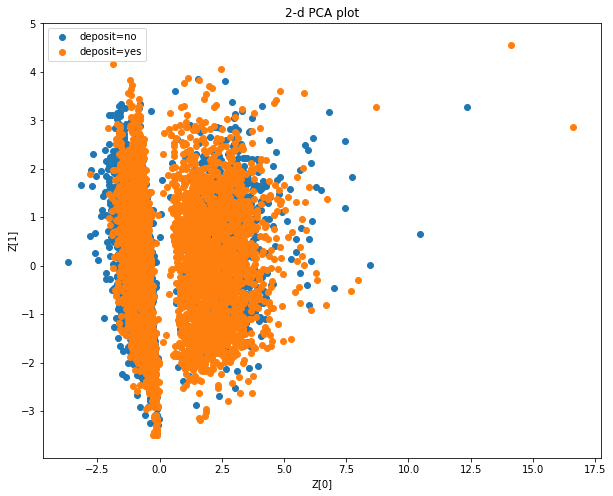

In [15]:
# If we take the labels into account, let's see how the data is separated

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(Z_2d[df[target] == 'no', 0], Z_2d[df[target] == 'no', 1], label='deposit=no')
ax.scatter(Z_2d[df[target] == 'yes', 0], Z_2d[df[target] == 'yes', 1], label='deposit=yes')
ax.legend()
ax.set(xlabel='Z[0]', ylabel='Z[1]', title='2-d PCA plot')

In [16]:
# to inspect the columns after scaling
pd.DataFrame(X_scaled, columns=features).describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
count,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04,1.116200e+04
mean,2.261425e-16,9.437194e-17,-1.322033e-15,5.147229e-15,2.846550e-15,9.961372e-17,-5.771628e-15,1.167022e-15,-8.658844e-15,3.354441e-16,-8.027991e-15,-8.213994e-15,1.395820e-15,-1.448412e-15
std,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00,1.000045e+00
min,-1.950161e+00,-1.391604e+00,-1.917331e+00,-1.714823e+00,-1.236166e-01,-2.596850e+00,-9.476162e-01,-3.879232e-01,-5.981494e-01,-1.065918e+00,-5.541683e-01,-4.811841e-01,-3.632598e-01,-2.470600e+00
25%,-7.749580e-01,-1.081525e+00,-3.186719e-01,-3.805006e-01,-1.236166e-01,-4.360996e-01,-9.476162e-01,-3.879232e-01,-5.981494e-01,-6.741146e-01,-5.541683e-01,-4.811841e-01,-3.632598e-01,-4.763969e-01
50%,-1.873565e-01,-1.512891e-01,-3.186719e-01,-3.805006e-01,-1.236166e-01,-3.033975e-01,-9.476162e-01,-3.879232e-01,-5.981494e-01,-3.370484e-01,-1.867854e-01,-4.811841e-01,-3.632598e-01,5.207046e-01
75%,6.520742e-01,7.789471e-01,1.279987e+00,9.538215e-01,-1.236166e-01,5.564233e-02,1.055280e+00,-3.879232e-01,6.233185e-01,3.572503e-01,1.805976e-01,-2.811903e-01,7.305850e-02,5.207046e-01
max,4.513455e+00,2.019262e+00,1.279987e+00,2.288144e+00,8.089529e+00,2.470351e+01,1.055280e+00,2.577830e+00,1.844786e+00,1.010912e+01,2.222358e+01,7.380638e+00,2.494320e+01,5.207046e-01


## Outlier detection


In [17]:
from sklearn.covariance import EllipticEnvelope

# contaimnation can be tuned - percentage of the data
# you think are outliers (e.g. 0.001 = 0.1%)
ee = EllipticEnvelope(contamination=1e-3) 
ee.fit(Z_2d) # use PCA because this method doesn't
             # work well on high dimensional data
             # just a visual aid

outlying = ee.predict(Z_2d)
print('outlier detection results: ',
      pd.Series(outlying).value_counts())

outlier detection results:   1    11150
-1       12
dtype: int64


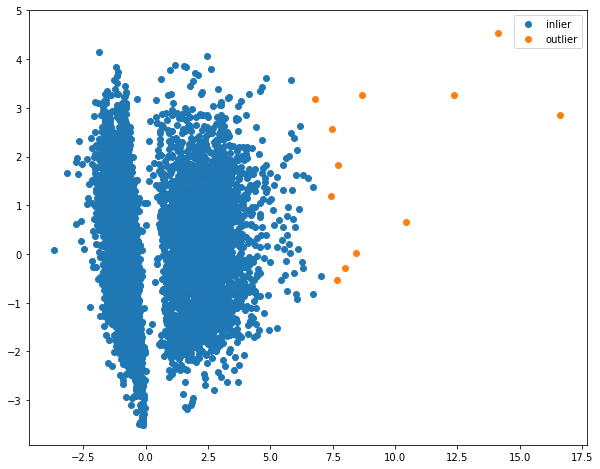

In [18]:
# plot the outliers
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z_2d[outlying==1, 0], Z_2d[outlying==1, 1], label='inlier')
ax.scatter(Z_2d[outlying==-1, 0], Z_2d[outlying==-1, 1], label='outlier')
ax.legend()

## Clustering

At this point, the features can be clustered.  We'll try:

- K-means, including finding k using elbow plot
- Hierarchical clustering

In [19]:
# we will be clustering just the inliers
X_inliers = X_scaled[outlying==1]
Z_inliers = Z_2d[outlying==1]

print(X_inliers.shape)
print(Z_inliers.shape)

(11150, 14)
(11150, 2)


In [20]:
X_scaled.shape

(11162, 14)

### K-means

* K-means
* Elbow plot
* Metrics

0.19688710158261513


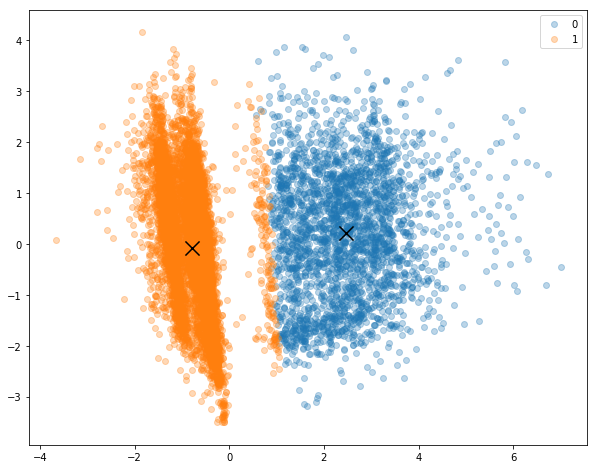

In [21]:
from sklearn.cluster import KMeans

# Basic k-means: random init centroids, n_init=1
# just to see how it works
# kmeans = KMeans(n_clusters=2, init='random', n_init=1, max_iter=200)

# default kmeans
kmeans = KMeans(n_clusters=2)

# get the clusters
clusters = kmeans.fit_predict(X_inliers)

# get the centroids (centre of clusters)
centroids = kmeans.cluster_centers_

# plot the clusters and centroids
fig, ax = plt.subplots(figsize=(10, 8))

# for each cluster, scatter plot a different colour
for i in range(kmeans.n_clusters):
    ax.scatter(Z_inliers[clusters == i, 0],
               Z_inliers[clusters == i, 1],
              label=i, alpha=.3) # make transparent by setting alpha
ax.legend()

# add the centroids to the plot
# pca from 16d to 2d in order to add to plot
centroids_2d = pca_2d.transform(centroids)
ax.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
           marker='x', color='black', s=200)

from sklearn.metrics import silhouette_score
print(silhouette_score(X_inliers, clusters))

In [22]:
# Elbow plot to help select k for k-means

# current inertia (sum of squared distances to centroid)
# how compact the clusters are
# smaller is better (shorter distance)
kmeans.inertia_

131347.64903982752

In [23]:
inertias = []
for k in range(2, 15):
    # fit and save inertia for each k
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    kmeans.fit(X_inliers)
    inertias.append(kmeans.inertia_)
    
print(inertias)

[131347.64882792483, 120267.54477968469, 109991.06885191899, 102734.47606537583, 95507.57366002482, 91187.41350823942, 86577.51871000076, 81940.12353992458, 79060.16901185186, 77287.02183869721, 73740.53998444836, 71944.64350707692, 70100.27444034633]


[Text(0, 0.5, 'inertia or gradient'),
 Text(0.5, 0, 'k'),
 Text(0.5, 1.0, 'Elbow plot')]

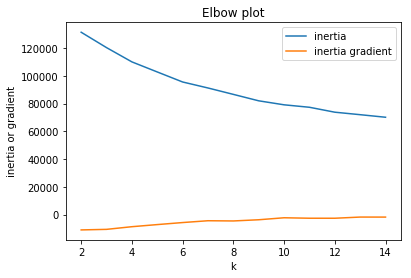

In [24]:
import numpy as np

gradient = np.gradient(inertias)

fig, ax = plt.subplots()

# plot inertias vs. k
ks = list(range(2, 15)) # convert to list of numbers
ax.plot(ks, inertias, label='inertia')
ax.plot(ks, gradient, label='inertia gradient')
ax.legend()
ax.set(title='Elbow plot', xlabel='k', ylabel='inertia or gradient')

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\numpy\core\fromnumeric.py:83

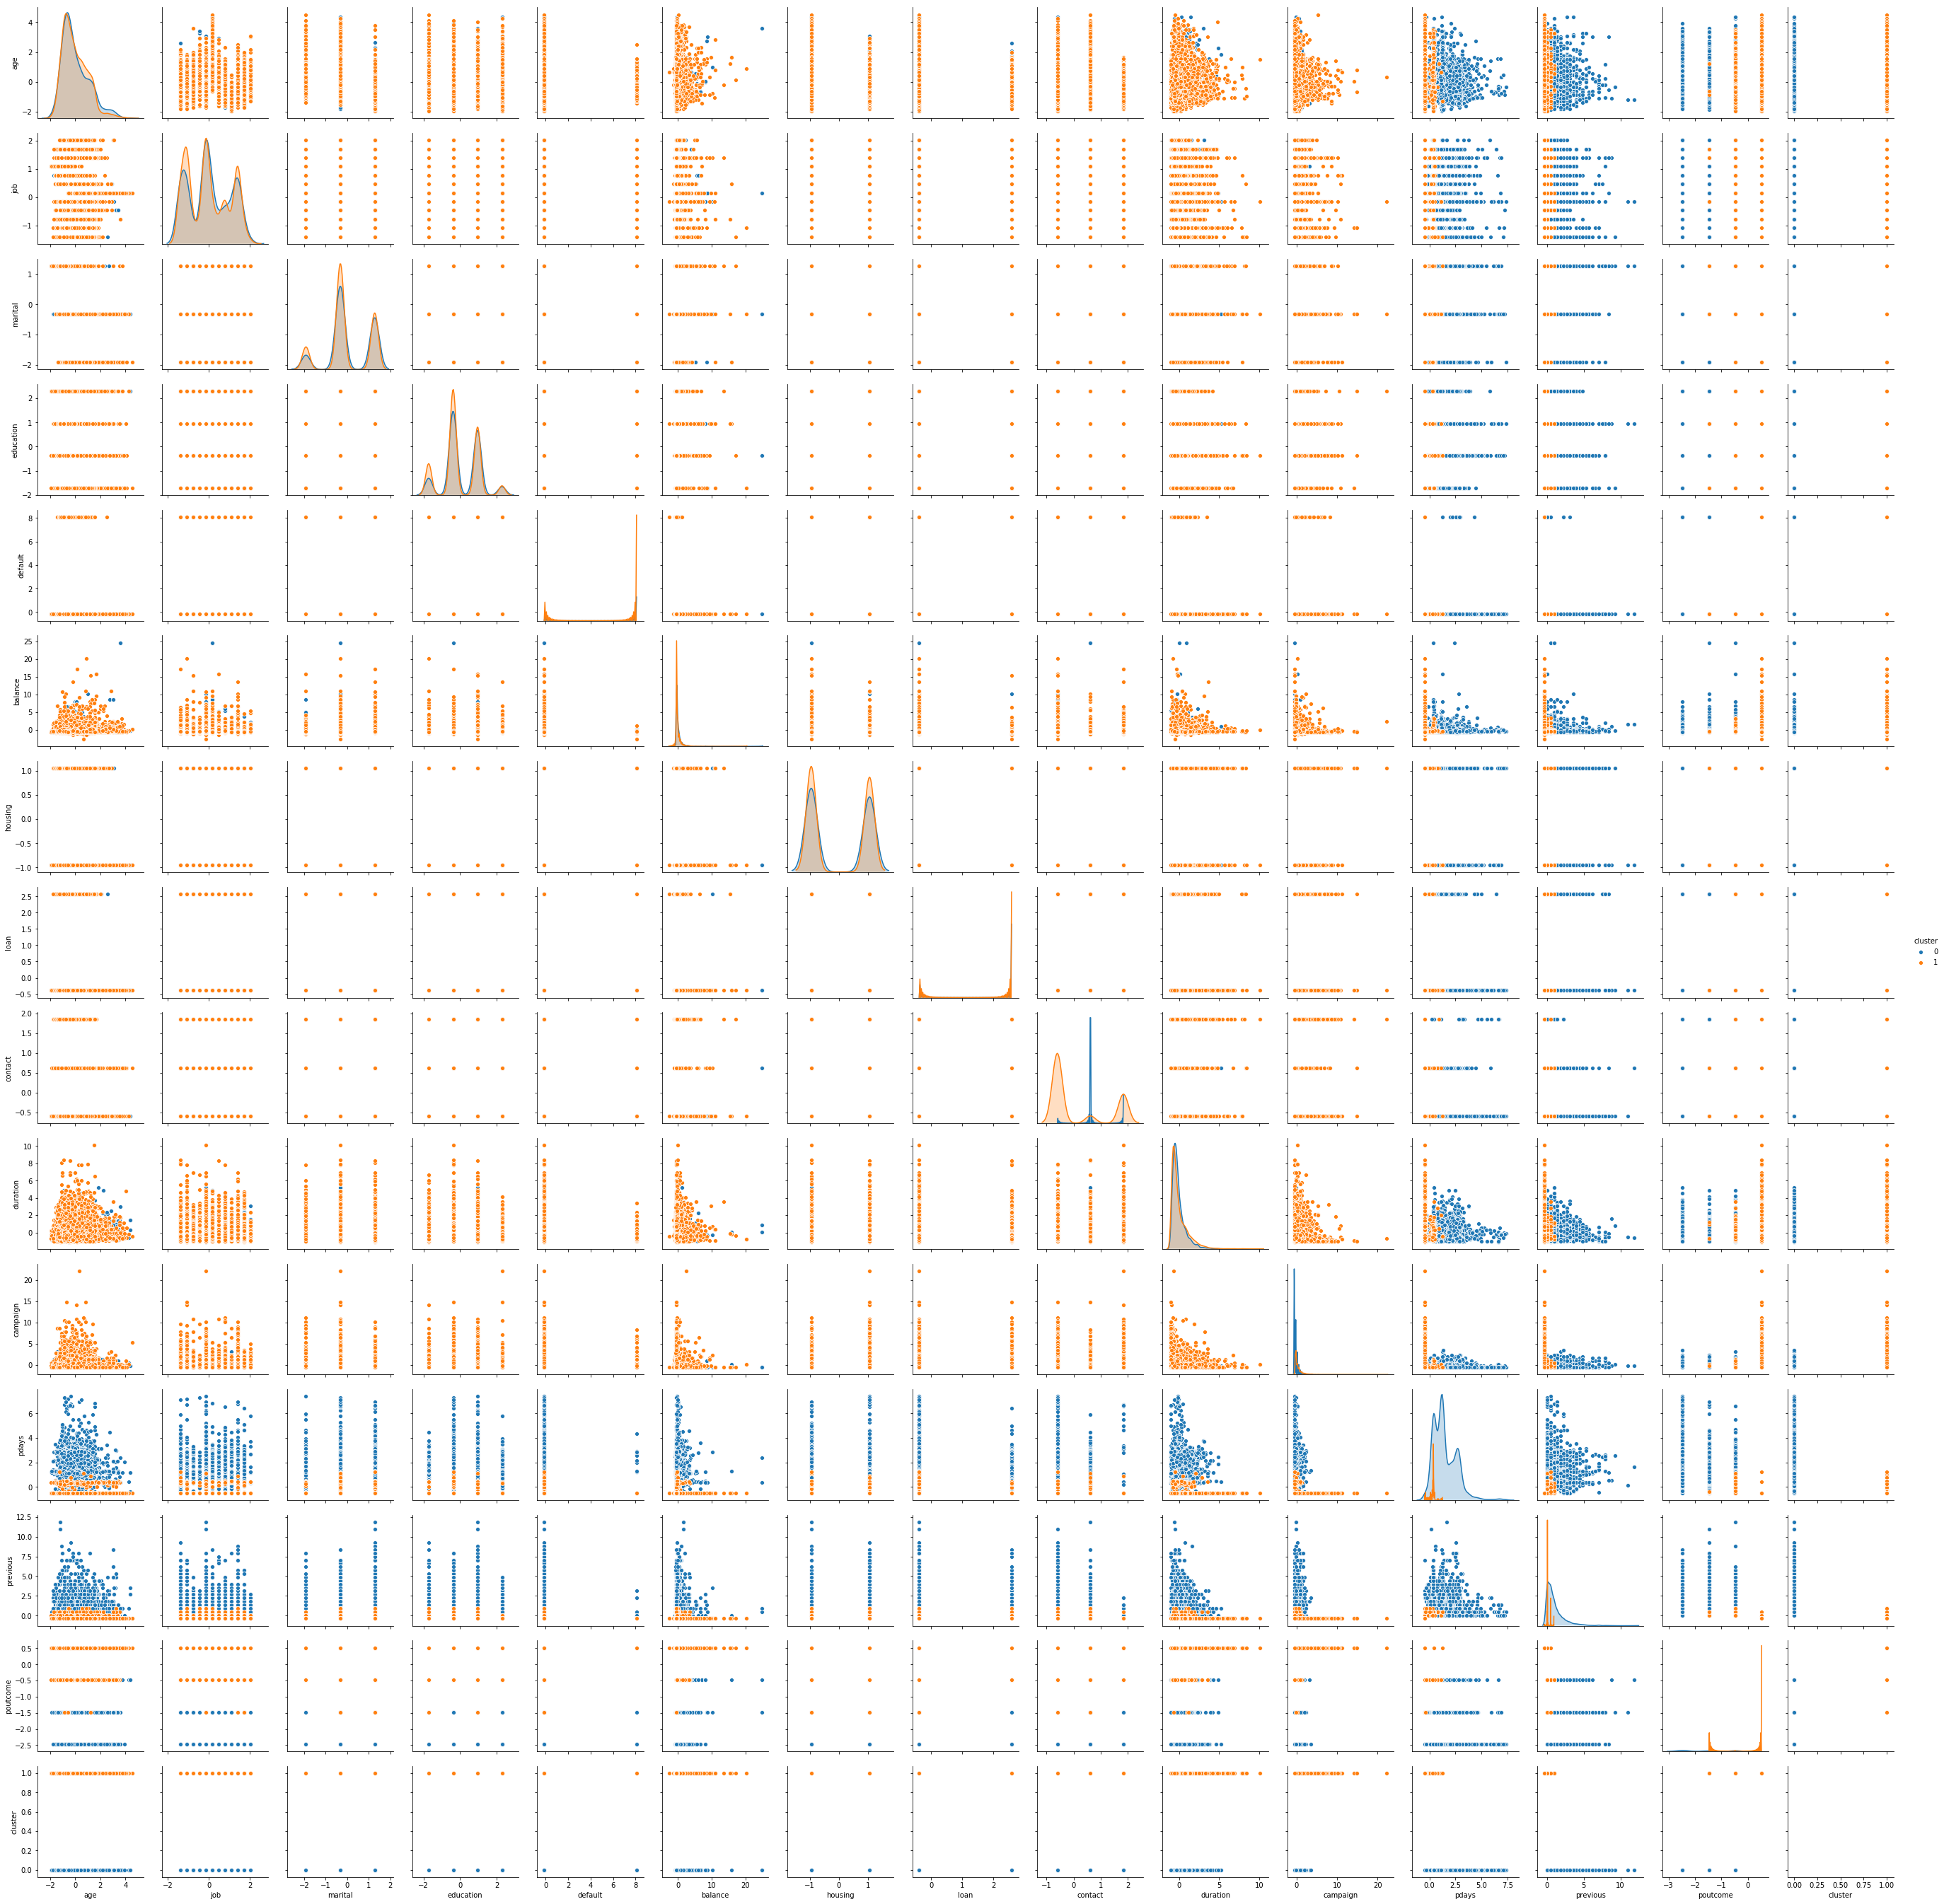

In [25]:
# exploring the clusters by using a pairplot of
# each feature with the cluster id
# hopefully can see a trend ???

# concat X_inliers with clusters
df_clusters = pd.DataFrame(X_inliers, columns=features)

# adds a column called 'cluster' with the cluster ids
# found by K-means (or any clustering algo)
df_clusters['cluster'] = clusters

sns.pairplot(df_clusters, hue='cluster')

### Hierarchical Clustering
* Visualisation using Dendrogram
* Cluster

[Text(0, 0.5, 'Inter-cluster distance'), Text(0.5, 1.0, 'Dendrogram')]

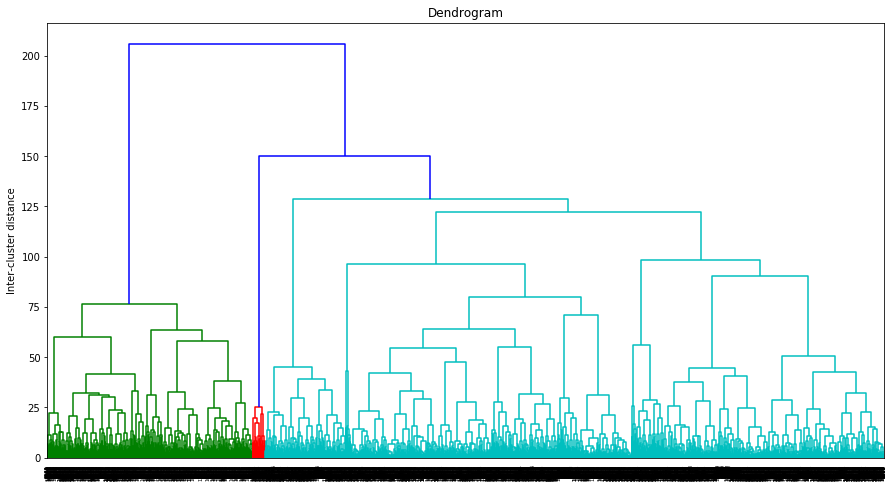

In [26]:
# for visualisation
from scipy.cluster.hierarchy import dendrogram, linkage

# Note: may take a while to run due to number of samples
links = linkage(X_inliers, 'ward')

fig, ax = plt.subplots(figsize=(15, 8))
dendrogram(links, ax=ax)

ax.set(title='Dendrogram', ylabel='Inter-cluster distance')

In [27]:
# based on dendrogram, let's say our threshold is 110, then
# number of clusters will be 5 (cut through 5 lines horizontally)
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
clusters_agg = agg.fit_predict(X_inliers)

print(silhouette_score(X_inliers, clusters_agg))

clusters_agg

0.19961024803624428


array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

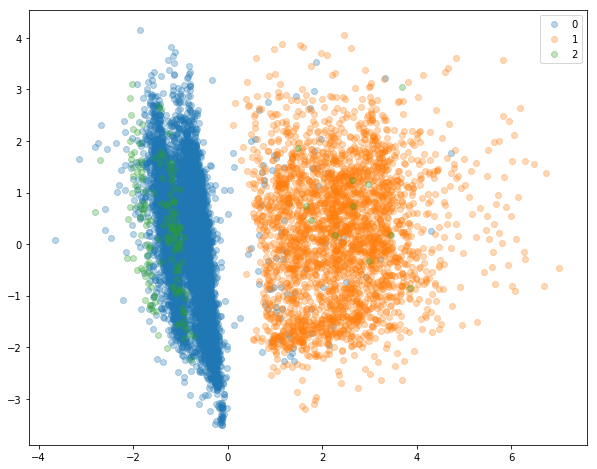

In [28]:
# plot the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# for each cluster, scatter plot a different colour
for i in range(agg.n_clusters):
    ax.scatter(Z_inliers[clusters_agg == i, 0],
               Z_inliers[clusters_agg == i, 1],
              label=i, alpha=.3) # make transparent by setting alpha
ax.legend()


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\numpy\core\fromnumeric.py:83

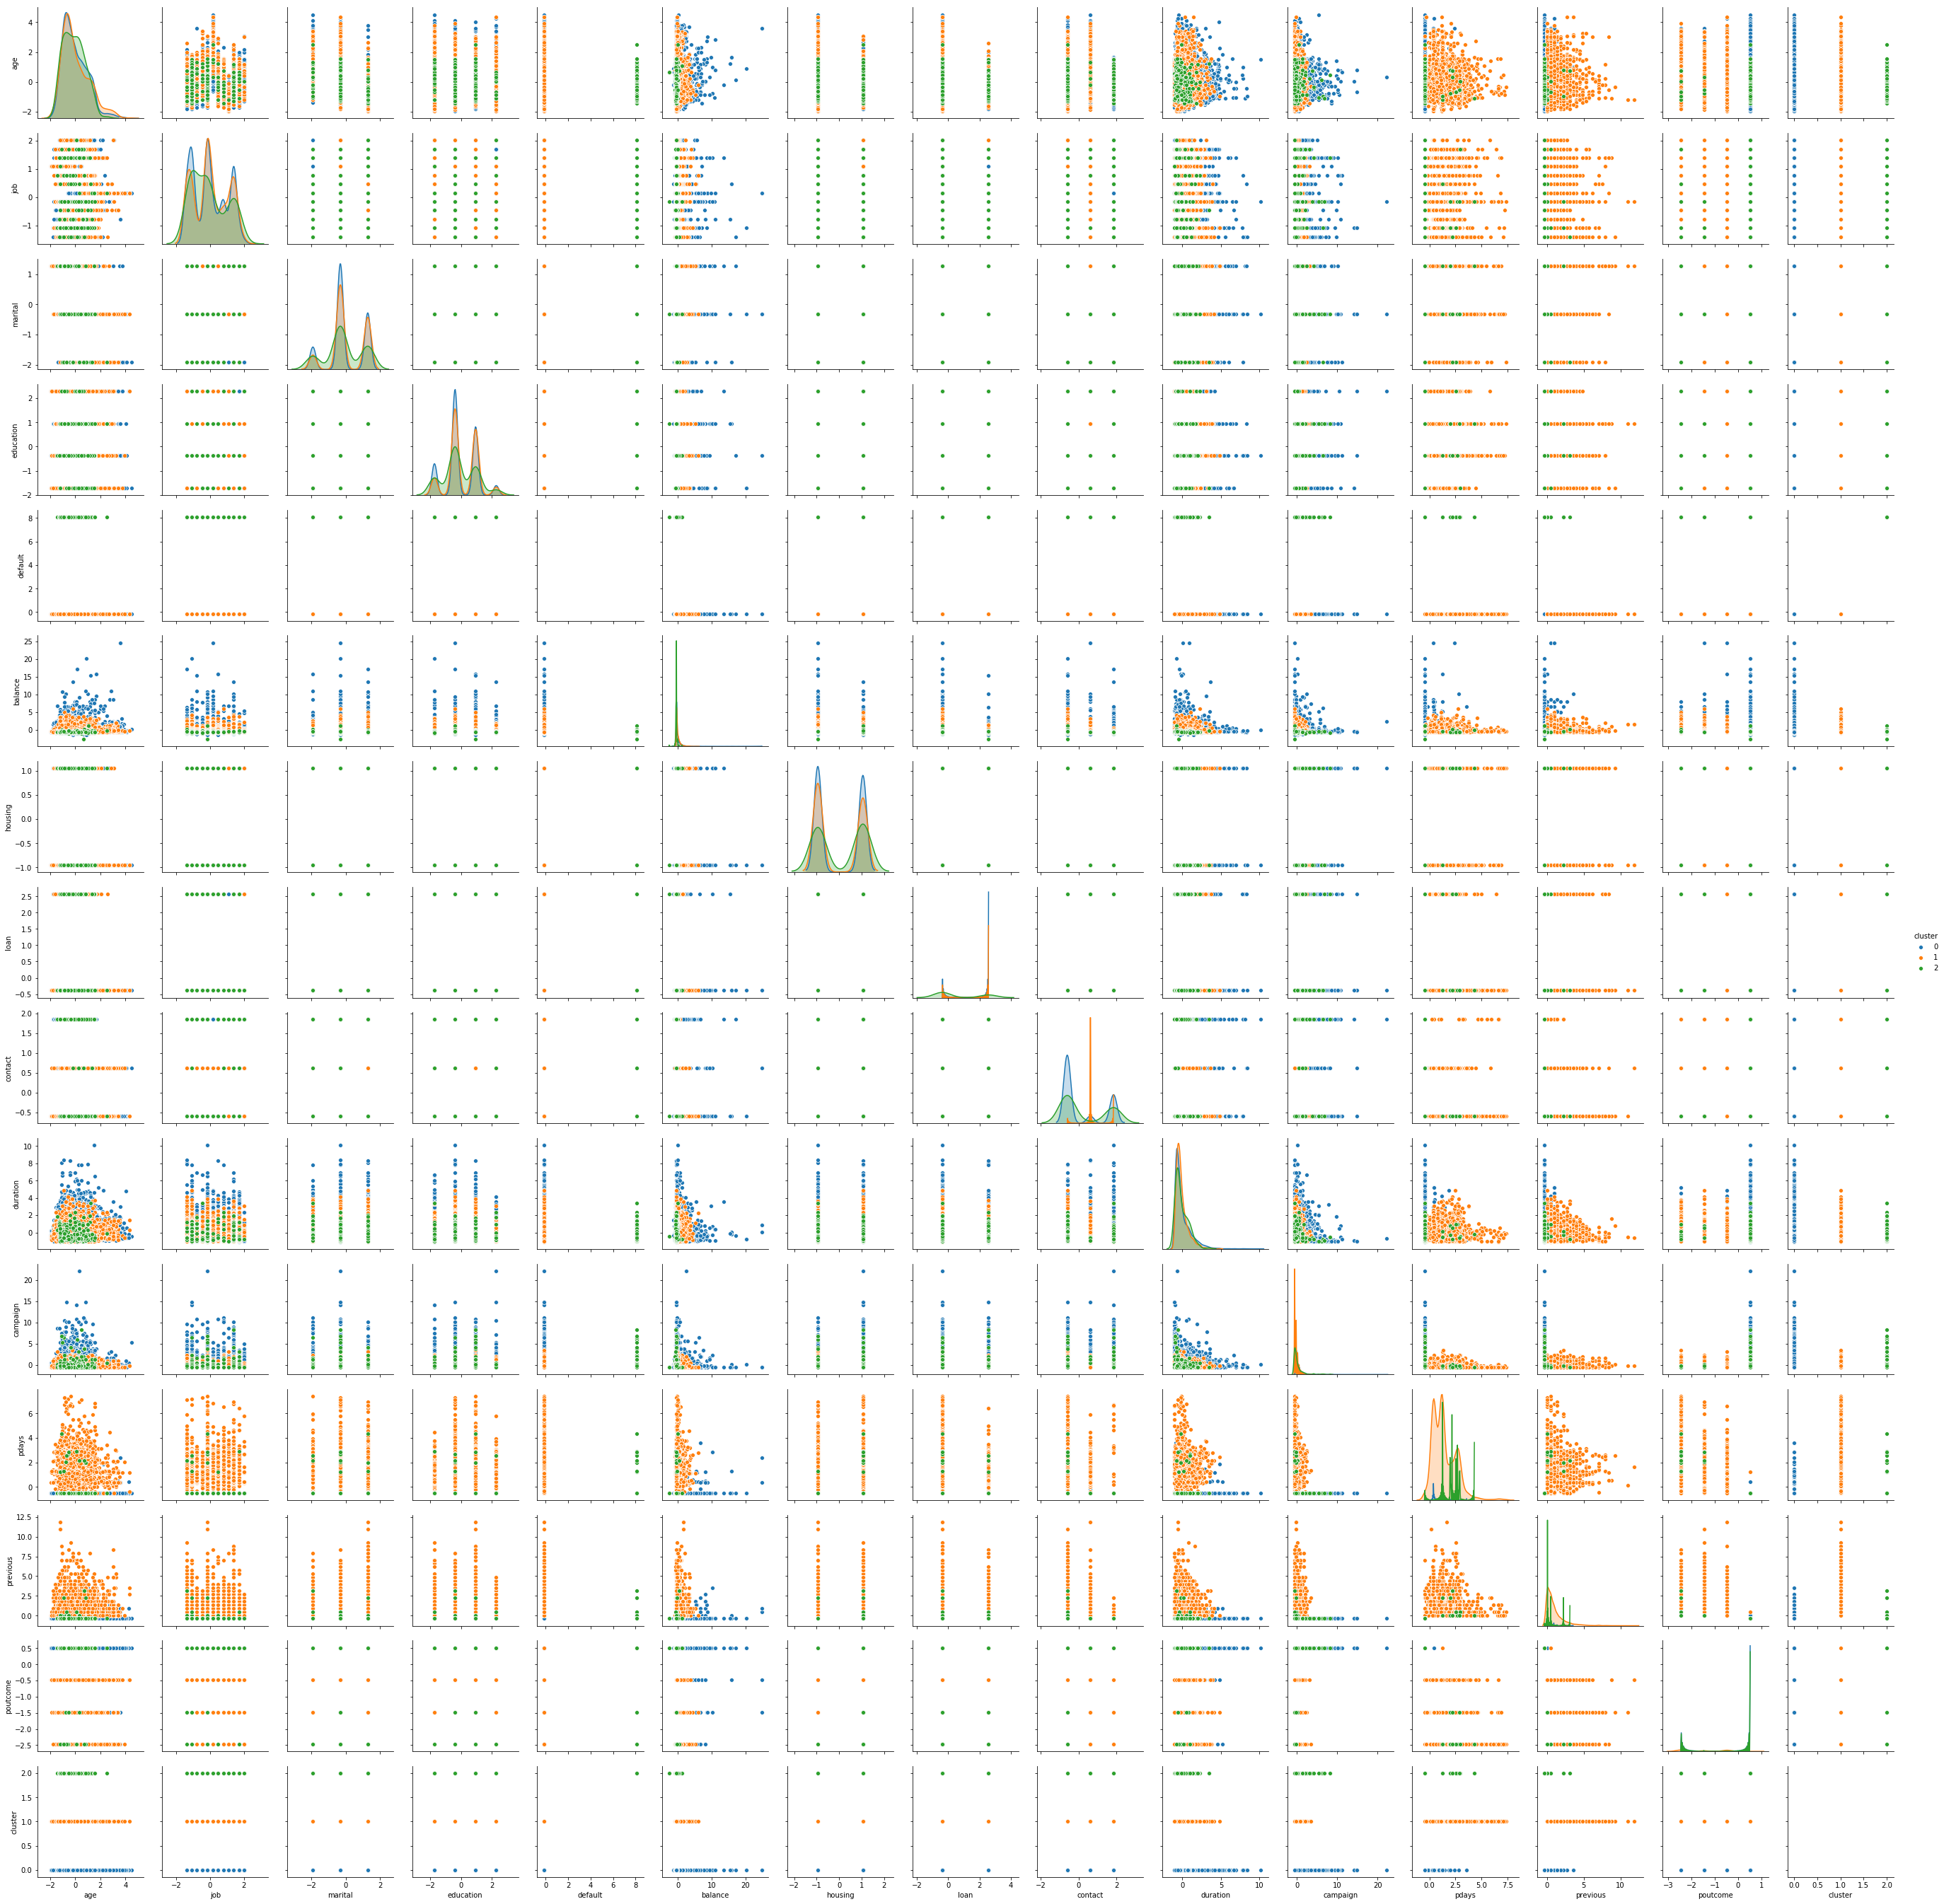

In [29]:
# exploring the clusters by using a pairplot of
# each feature with the cluster id

# concat X_inliers with clusters
df_clusters_agg = pd.DataFrame(X_inliers, columns=features)

# adds a column called 'cluster' with the cluster ids
# found by Hierarchical clustering
df_clusters_agg['cluster'] = clusters_agg

sns.pairplot(df_clusters_agg, hue='cluster')